# <u>***Real Estate Analytics: Module 7 Assignment*** </u>

#### You should use the research grid to work on this problem set.

This Problem set has two questions.

In [1]:
import sys, os

if 'dx2191' in os.getcwd():
    sys.path.append(r"/user/dx2191/REA/Module6/") # developer's path (ignore this)
else:
    module_path = r"/shared/share_realestate_analytics/Module6_7_resi_mortgage/" # path to the shared folder
    if module_path not in sys.path:
        sys.path.append(module_path)

from Code.settings import *
import Code.Util as util
import Code.read_data as data_reader
import Code.default_analysis as da

from IPython.display import Markdown, display
# Added imports and settings: 
pd.set_option('display.max_columns', None) #Allows us to see all columns
import matplotlib.ticker as ticker
from sklearn.preprocessing import OneHotEncoder

# Question 1: Rate Spread Between Prime and Subprime Mortgages

Following the tests in the class, we will now try to predict crisis with the spread between prime and sub-prime mortage rate. In this question, you will calculate and analyze this spread using the Freddie Mac dataset. 

Define:
- Group 1 (G1) as mortgages taken out by individuals with FICO scores <= 660 and mortgages LTV >= 0.75
- Group 2 (G2) as mortgages taken out by individuals with FICO scores >= 760 and mortgages LTV <= 0.4

We will take `G1` as the prime mortgages and `G2` as the subprime mortgages. This is not a precise definition, but it will suffice for our analysis. Also, only consider 30 Year FRMs in the analysis for comparability.

--------------------------
1. First compute the spread within each vintage: 

$$Spread_t = R_{t, G_1} - R_{t, G_2}$$

, where $R_{t, G_g}$ is the average mortgage rate at origination for group $g$ in vintage $t$.

Also compute the `relative spread` as follows:
$$Relative Spread_t = Spread_t / R_t $$

, where $R_t$ is the average mortgage rate at origination for vintage $t$.

2. Make a line chart of the number of mortgages (from the sample you have) that belong to `G1` and `G2` for each quarter. What do you observe?

3. Plot the spread and the relative spread over time. What happened before each NBER recession? Also comment on the trend over time. 

4. Study the determinants of this spread. Regress the spread above on various mortgage characteristics in that vintage. Specifically,

$$\text{Spread}_{t} = \alpha + \beta [X]$$

where [X] is a vector including the log(average Credit Score), average Cumulative LTV, and MORTGAGE30US for each vintage. You can use the average valuesfrom the pickle file `spread_stats_dict_ps6.pkl` (calculated on the full sample). 

5. Examine the fitted and the residual components. Plot the relative spread (Y) and the estimated values ($\hat{Y}$) in one chart, and then the residuals ($\epsilon$) in another plot.

You can now complete the codes below following the guidances:

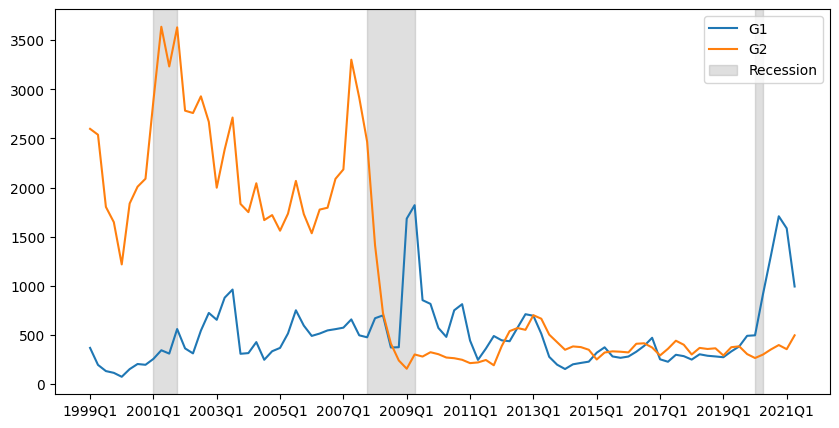

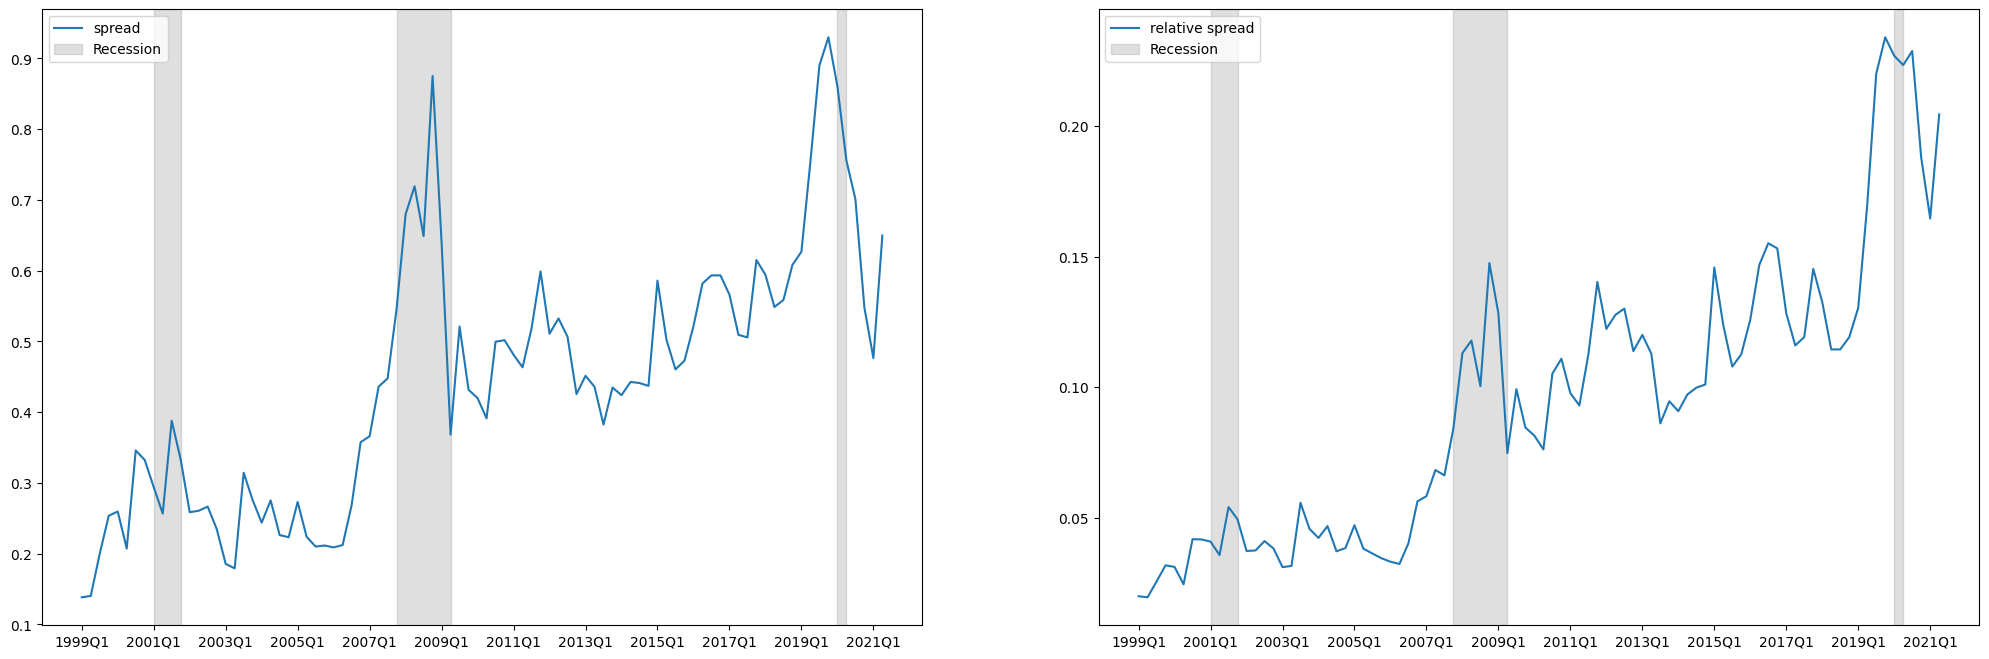

In [2]:
# First, load a cleaned 5% sub-sample of the origination dataset
origination_data_full_sample = pd.read_pickle(module7_preprocessed_Data+ '/origination_data_full_sample.pkl')
# remove the quarters after 2021Q2 as we don't have nonstandard mortgage data after that
quarters_str = quarters_str[:(quarters_str.index('2021Q2'))+1]   
origination_data_full_sample[quarters_str] = origination_data_full_sample[quarters_str].fillna(0)

# Subset to get 30Y FRMs
# ---------------- 1 Line ----------------#
df = origination_data_full_sample[(origination_data_full_sample['amort_type'] == "FRM")&(origination_data_full_sample['loan_term'] == 360) ]
# Calculate avg. interest rate for mortgages in Groupe G1 and G2 for every quarterly vintage (Use groupby and conditional mean) and the avg. rate for full sample
# ---------------- 2-4 Lines ----------------#
df['Group'] = np.select([((df['ltv'] <=.4)& (df['crdt_scr'] >=760)), ((df['ltv'] >=.75) & (df['crdt_scr'] <=660))],['G1', 'G2'],np.NaN)

average_rates = df.groupby(['quarter','Group'])['int_rate'].mean().reset_index() # Get average rates by quarter & group
average_rates = average_rates[average_rates['Group'] != 'nan'] #Remove the non G1 and G2 rows
average_rates = average_rates.pivot(index='quarter',columns='Group',values='int_rate').reset_index() # pivot the df

average_rates_overall = df.groupby('quarter')['int_rate'].mean().reset_index() #get overall average rate
average_rates = average_rates.merge(average_rates_overall, on='quarter') #combine overall with group rates
average_rates.columns = ['quarter','G1_rate','G2_rate','overall_rate'] #rename columns
# Calculate the number of mortgages in each bucket
# ---------------- 2 Lines ----------------#
mortgage_counts = df.groupby(['quarter','Group'])['int_rate'].count().reset_index() # Get counts by quarter & group
mortgage_counts = mortgage_counts[mortgage_counts['Group'] != 'nan'] #Remove the non G1 and G2 rows
mortgage_counts = mortgage_counts.pivot(index='quarter',columns='Group',values='int_rate').reset_index() # pivot the df
mortgage_counts.columns = ['quarter','count_G1', 'count_G2'] # rename cols
average_rates = average_rates.merge(mortgage_counts, on='quarter') # merge back with main
# Calculate relative spread for each vintage. Define Relative spread as (Rate of G1 - Rate of G2) / (Rate of G) where G is all mortgages in the subset
# ---------------- 1-2 Lines ----------------#
average_rates['spread'] = average_rates['G2_rate'] - average_rates['G1_rate']
average_rates['relative_spread'] = average_rates['spread'] / average_rates['overall_rate']
# Plot the number iof mortgages in each bucket (add NBER recessions)
# ---------------- 4-8 Lines ----------------#
def add_recessions(plot='None'):
    if plot == 'None':
        ax.axvspan('2001Q1', '2001Q4', color='grey', alpha=0.25, label='Recession')
        ax.axvspan('2007Q4', '2009Q2', color='grey', alpha=0.25)
        ax.axvspan('2020Q1', '2020Q2', color='grey', alpha=0.25)
    else:
        ax[plot].axvspan('2001Q1', '2001Q4', color='grey', alpha=0.25, label='Recession')
        ax[plot].axvspan('2007Q4', '2009Q2', color='grey', alpha=0.25)
        ax[plot].axvspan('2020Q1', '2020Q2', color='grey', alpha=0.25)
    return
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(average_rates['quarter'], average_rates['count_G1'], label='G1')
ax.plot(average_rates['quarter'], average_rates['count_G2'],label='G2')
add_recessions()
ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
plt.legend()
plt.show()
# Plot the spread and the relative spread in two separate plots (add NBER recessions)
# ---------------- 4-8 Lines ----------------#
fig, ax = plt.subplots(1, 2, figsize = (25, 8))
ax[0].plot(average_rates['quarter'], average_rates['spread'], label='spread')
add_recessions(0)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(8))
ax[0].legend()

ax[1].plot(average_rates['quarter'], average_rates['relative_spread'], label='relative spread')
add_recessions(1)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(8))
ax[1].legend()
plt.show()
# What are your observations?

### Observations:

For chart 1, I notice that the number of G2 mortgages has declined sharply since the great recession. This is expected as stricter regulations on mortgage lending were put in place afterwards that limited the ability of banks to lend to weaker applicants. Additionally, it seems that the number of G1 mortgages spikes around recessions. This is most likely financially stable borrowers taking advantage of the lower rate environments to refinance their homes. 

For charts 2 and 3, I notice that the general trend for both spread and relative spread is increasing over time. This is probably the result of banks generally becoming more cautious and giving tougher terms to weaker applicants. I also notice that the spread and relative spread seem to spike during recessions. This could be because banks are more cautious during times when there is more pressure on the economy. 

In [3]:
# Read pickle file 'spread_stats_dict_ps6.pkl' to get the average values of mortgage rate determinants from the full dateset.
spread_determinants = util.readPickle(pset_6_data_path, 'spread_stats_dict_ps6.pkl')

# Read the 30Y mortgage Rate
mortgage_rates = data_reader.return_rates_30y('default')

# merge the 30Y mortgage rate with the characteristics (clean the time column before merging!)
# ---------------- 4-6 Lines ----------------#
mortgage_rates['year'] = mortgage_rates['rep_period'].dt.year
mortgage_rates['quarter'] = mortgage_rates['rep_period'].dt.quarter
mortgage_rates['rep_period'] = mortgage_rates['year'].astype(str) + 'Q' + mortgage_rates['quarter'].astype(str)
mortgage_rates.drop(['year','quarter'],axis=1, inplace=True)
mortgage_rates = mortgage_rates.groupby('rep_period')['MORTGAGE30US'].mean().reset_index() #get avg rate over quarter
#merge the data:
spread_determinants = spread_determinants.reset_index()
spread_determinants.rename(columns={'index':'rep_period'},inplace=True)
characteristics = spread_determinants.merge(mortgage_rates, on='rep_period')
# merge the spread determinants with the relative spread calculated above
# ---------------- 2-3 Lines ----------------#
characteristics.rename(columns={'rep_period':'quarter'},inplace=True)
average_rates = average_rates.merge(characteristics, on='quarter')
# Regress the relative spread on log(Credit Score), Cumulative LTV and Mortgage Rate and record the fitted and residual component
# ---------------- 2-3 Lines ----------------#
average_rates['log_crdt_scr'] = np.log1p(average_rates['crdt_scr'])
reg1, _ = util.run_OLS_reg(average_rates,'relative_spread',['log_crdt_scr','cltv','MORTGAGE30US'])
average_rates['fitted_values'] = reg1.fittedvalues
average_rates['residuals'] = reg1.resid

                            OLS Regression Results                            
Dep. Variable:        relative_spread   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     70.45
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           4.30e-23
Time:                        14:18:48   Log-Likelihood:                 190.64
No. Observations:                  90   AIC:                            -373.3
Df Residuals:                      86   BIC:                            -363.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.6517      2.129     -1.715   

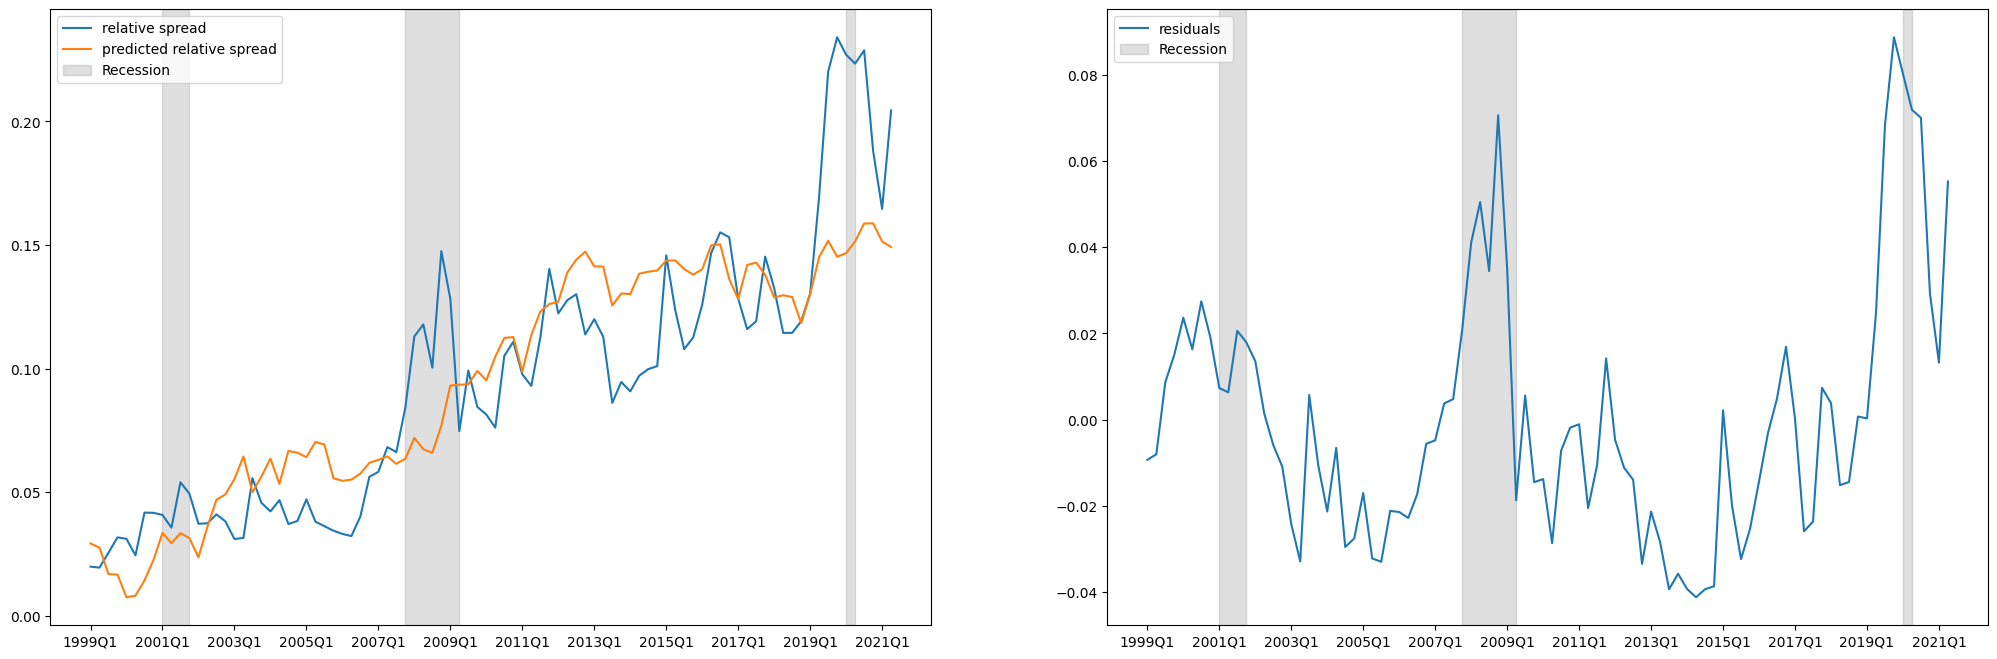

In [4]:
# Plot the fitted and residual components (Add NBER Recessions)
# ---------------- 8-15 Lines ----------------#
fig, ax = plt.subplots(1, 2, figsize = (25, 8))
ax[0].plot(average_rates['quarter'], average_rates['relative_spread'], label='relative spread')
ax[0].plot(average_rates['quarter'], average_rates['fitted_values'], label='predicted relative spread')
add_recessions(0)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(8))
ax[0].legend()

ax[1].plot(average_rates['quarter'], average_rates['residuals'], label='residuals')
add_recessions(1)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(8))
ax[1].legend()
plt.show()

### Observations

Above, we see that the predictions tend to be the worst around recessions. We also see that the resididuals are highest around recessions. This likely indicates that our model is not capturing something about recessions that is important to determining spread. 

# Question 2

In this exercise, you will examine the relationship between macro credit standards and mortgage rates. 

We will use credit standard measures from the Senior Loan Officer Opinion Survey on Bank Lending Practices dataset from FED, [here](https://www.federalreserve.gov/data/sloos.htm). You can directly read the data from `credit_standards.csv` under the `pset_6_data_path`.
- We will look at 'Measures of Supply and Demand for Residential Mortgage Loans' and get data for "Net Percentage of Domestic Respondents Tightening Standards for Mortgage Loan". This is a measure of whether the credit standards were tightened or liberalized. Tightening of credit standard implies making it harder for individuals to take out mortgages unless they are high quality borrowers. That is the column 'Tightening Standards' in the dataset. 

We will then need to get the mortgage rates across time. This will be achieved by fitting a model to remove the `selection bias` in the data.

We will just borrow the model from Section 7.1 in Module 7A. You can use the code from the lecture notes. The only change you need to make is to use the `alternative specification` (see below for details) instead.

After you fit the model, plot together the vintage effect time series and the measure of credit standards. What do you observe?

--------------------

In Section 7.1, we saw the effect of the vintage on default 

$$\text{Vintage Effect}_t = exp(\alpha_v + \beta'\bar{x_t})$$

where: 


$\alpha_v$ is the vintage dummy and  is a vector of controls (more on it below). In this question, you will compare the vintage effect, with the measure of credit standard above. However, you will use an alternative specification of the proportional odds. Specifically,

Default Probability $P_{i,t}$ defined as 0-60 days delinquent/default in 2 months

$$log \big(\frac{P_{i,t}}{1 - P_{i,t}} \big) = \alpha_t + \gamma_v + \beta'x_{i,t} + \epsilon_{i, t}$$

$\alpha_t$ is an age dependent constant to calculate age effects

$\gamma_v$ vintage dummy 

##### Product/Property Controls

1. Interest Rate on Mortgage at origination adjuste for latest applicable rate for ARMs 
2. ARM/FRM Flag
3. Cash Out Refinance Flag
4. Non-Cash Out Refinance Flag
5. Multiple Borrower Flag
6. Investment Property Flag
7. First Time Home Buyer Flag
8. Prepayment Penalty Flag

##### Mortgage-Month Controls

1. Unpaid Principal Balance
2. Effective Loan To Value

##### Macro

1. Unemployment
2. State Home Price Growth Rate
3. Mortgage Rate (MORTGAGE30US)
4. Median Household Income

##### **Borrower Characteristics (Alternative Specification)**
You will have to construct the following dummies by yourself:
       
1. Debt to Income Dummies (<30%, 30%-35%, 35%-40%, >40%)
2. FICO Score Dummies (<660, 660-700, 700-750, 750-800, >800)
3. Cumulative LTV Dummies (<60%, 60%-70%, 70%-80%, 80%-90%,>90%)


In [5]:
# Reading this massive pickle takes a minute
all_Data = pd.read_pickle(module7_preprocessed_Data+ '/marginals_temp.pkl')

# About 16 Million observations and 130 columns (so about 660 thousand mortgages)
# Remember to request enough memory to load the data (use command notebook --grid_mem=xxG)
print(all_Data.shape)
all_Data.head()

(16408505, 133)


,seq_num,age,rep_period,cur_upb,cur_int_rate,new_default,int_rate,ARM,CO_refi,NC_refi,multi_borrow,Investment_prop,first_home_buyer,prepayment_penalty,dti,crdt_scr,cltv,upb,High_cltv_low_fico,prop_state,1999Q1,unemployment,home_price_growth,household_income,MORTGAGE30US,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_5,AGE_6,AGE_7,AGE_8,AGE_9,AGE_10,AGE_11,AGE_12,AGE_13,AGE_14,AGE_15,AGE_16,AGE_17,AGE_18,AGE_19,AGE_20,AGE_21,AGE_22,AGE_23,1999Q2,1999Q3,1999Q4,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,2002Q3,2002Q4,2003Q1,2003Q2,2003Q3,2003Q4,2004Q1,2004Q2,2004Q3,2004Q4,2005Q1,2005Q2,2005Q3,2005Q4,2006Q1,2006Q2,2006Q3,2006Q4,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,quarter
0,A99Q10000997,0,1999-03-31,50000.0,0.06875,0.0,0.06875,1,0,0,0,0,0,0,0.39,760.0,0.75,50.0,0,IL,1.0,0.042,0.035696,68.724,0.0704,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999Q1
1,F99Q10002365,1,1999-03-31,60000.0,0.06875,0.0,0.06875,0,1,0,1,0,0,0,0.22,702.0,0.76,60.0,0,IL,1.0,0.042,0.035696,68.724,0.0704,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999Q1
2,F99Q10004241,1,1999-03-31,115000.0,0.07125,0.0,0.07125,0,0,1,1,0,0,0,0.23,770.0,0.88,116.0,0,IL,1.0,0.042,0.035696,68.724,0.0704,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999Q1
3,F99Q10004352,1,1999-03-31,112000.0,0.07125,0.0,0.07125,0,0,1,0,0,0,0,0.34,726.0,0.90,112.0,0,IL,1.0,0.042,0.035696,68.724,0.0704,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999Q1
4,F99Q10006300,1,1999-03-31,97000.0,0.07125,0.0,0.07125,0,0,0,0,0,0,0,0.20,661.0,0.80,98.0,0,IL,1.0,0.042,0.035696,68.724,0.0704,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999Q1


In [6]:
# Create additional variables for the alt specification (booleans for specific LTV, credir score or DTI ranges)

# - L1 = Least CLTV group; L5 = Highest LTV group
# - F1 = Least FICO group; F5 = Highest FICO group
# - D1 = Least DTI group; D4 = Highest DIT group

ltv_break_points = [0., 0.6, 0.7, 0.8, 0.9, 99.]
fico_break_points = [0., 660, 700, 750, 800, 999]
dti_break_points = [0., 0.3, 0.35, 0.4, 99.]

# ---------------- 6-9 Lines to generate group dummies----------------#
all_Data['ltv_group'] = np.select( [(all_Data['cltv'] < .6) & (all_Data['cltv'] > 0), all_Data['cltv'] < .7, all_Data['cltv'] < .8, all_Data['cltv'] < .9,all_Data['cltv'] < 1], ['L1','L2','L3','L4','L5'],'Other') 
all_Data['credit_group'] = np.select( [(all_Data['crdt_scr'] < 660) & (all_Data['crdt_scr'] > 0), all_Data['crdt_scr'] < 700, all_Data['crdt_scr'] < 750, all_Data['crdt_scr'] < 800,all_Data['crdt_scr'] < 999], ['F1','F2','F3','F4','F5'],'Other') 
all_Data['dti_group'] = np.select( [(all_Data['dti'] < .3) & (all_Data['dti'] > 0), all_Data['dti'] < .35, all_Data['dti'] < .4, all_Data['dti'] < 99], ['D1','D2','D3','D4'],'Other') 

encoder = OneHotEncoder(sparse_output=True)
all_Data = pd.concat([all_Data, pd.get_dummies(all_Data['ltv_group'], sparse=True)], axis=1)
all_Data = pd.concat([all_Data, pd.get_dummies(all_Data['credit_group'], sparse=True)], axis=1)
all_Data = pd.concat([all_Data, pd.get_dummies(all_Data['dti_group'], sparse=True)], axis=1)

In [7]:
for col in ['L1','L2', 'L3', 'L4', 'L5', 'F1','F2', 'F3', 'F4', 'F5','D1', 'D2', 'D3', 'D4']:
    all_Data[col] = all_Data[col].astype(int)

In [28]:
# Alternative specification names

alt_specification_predictors = ['cur_int_rate', 'ARM', 'CO_refi', 'NC_refi', 'multi_borrow', 'Investment_prop', 'first_home_buyer', 'prepayment_penalty',
                                 'upb', 'unemployment', 'home_price_growth', 'MORTGAGE30US', 'household_income'] + ['L2', 'L3', 'L4', 'L5', 'F2', 'F3', 'F4', 'F5',
                                                                                                                    'D2', 'D3', 'D4'] + ['AGE_{}'.format(i) for i in range(1, 24)] + quarters_str[1 : -6]

name_vars_main = ['Current Interest Rate', 'ARM', 'Cash Out Refinance Flag',  'Non-Cash Out Refinance Flag', 'Multiple Borrower Flag', 'Investment Property Flag', 'First Time Home Buyer Flag', 'Prepayment Penalty Flag',
              'Debt to Income',  'FICO Score',  'Cumulative LTV', 'Unpaid Principal Balance', 'Unemployment', 'Home Price Growth Rate', 'Mortgage Rate (MORTGAGE30US)', 'Median Household Income' ]


print("Alternative Specification #Predictors: {}".format(len(alt_specification_predictors)))

Alternative Specification #Predictors: 130


In [30]:
test = all_Data[alt_specification_predictors].copy()

In [32]:
# Train proportional odds model (Alternative Specification) using Maximum likelihood (re-use the code from the lecture notes)
# ---------------- 2 Lines ----------------#
model_alt_spec = LogisticRegression(fit_intercept = True, C = 1e9, max_iter = int(1e3), n_jobs = os.cpu_count() - 2)
model_alt_spec = model_alt_spec.fit(test, all_Data['new_default'])

In [9]:
# Read and store coefficients for the alternate specifications
# ---------------- 2-4 Lines ----------------#
coeffs_alt_spec = pd.DataFrame(dict(zip(alt_specification_predictors, model_alt_spec.coef_.tolist()[0])).items(), columns = ['param', 'coeff'])
main_cols_alt_spec = [i for i in alt_specification_predictors if ('AGE_' not in i) & ('Q' not in i)]
age_cols = [i for i in alt_specification_predictors if 'AGE_' in i]
quarter_cols = [i for i in alt_specification_predictors if 'Q' in i]
# calculate the vintage effect (use the code from lecture notes, re-use the functon get_vintage_effects() with modifications if required)
# ---------------- 6-10 Lines ----------------#
def get_vintage_effects(model_coeffs, model_main_predictors):
    # Calculate the mean of the predictors (X bar)
    mean_vintage_pred = all_Data[all_Data['quarter'] != '1999Q1'].groupby('quarter')[model_main_predictors + age_cols].mean()
    mean_vintage_pred = np.array(mean_vintage_pred)

    # Get the average effects (\hat{beta} times X bar)
    beta_X = np.array(model_coeffs[model_coeffs['param'].isin(model_main_predictors + age_cols)]['coeff'])
    
    # Get the vintage effect coefficients
    beta_vintage = np.array(model_coeffs[model_coeffs['param'].isin(quarter_cols)]['coeff'])
    
    # Calculate the vintage effect
    vintage_effect = np.exp(beta_vintage + np.dot(mean_vintage_pred, beta_X)) * 100

    vintage_effect = pd.DataFrame(dict(zip(quarter_cols, vintage_effect.tolist())).items(), columns = ['param', 'vintage effect'])
    vintage_effect = vintage_effect.set_index('param')
    
    return vintage_effect

alt_spec_vintage_effect = get_vintage_effects(coeffs_alt_spec, main_cols_alt_spec)

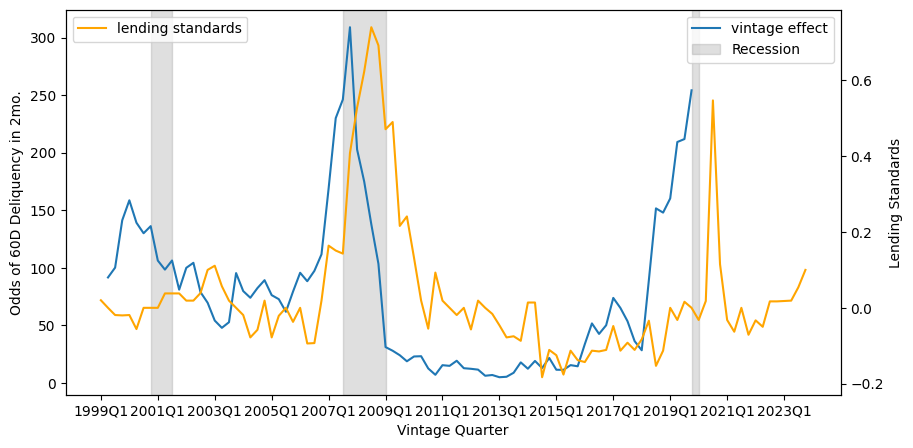

In [71]:
# Read SLOOS dataset
lending = pd.read_csv(os.path.join(pset_6_data_path, 'credit_standards.csv'))
lending['year'] = lending['Quarter'].apply(lambda x: x.split(':')[0]).astype(int)
lending['quarter'] = lending['Quarter'].apply(lambda x: x.split(':')[1]).astype(int)
lending['quarter'] = lending['year'].astype(str) + 'Q' + lending['quarter'].astype(str) 
lending = lending.set_index('quarter').drop(columns = ['Quarter', 'year'])

lending['Tightening Standards'] = lending['Tightening Standards'].astype(np.float64)
lending['Stronger Demand'] = lending['Stronger Demand'].astype(np.float64)

lending = lending / 100


# Plot the 'Tightening Standards' and the vintage effect time series (Add NBER Recessions)
# ---------------- 8-14 Lines ----------------#
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(alt_spec_vintage_effect.index, alt_spec_vintage_effect['vintage effect'], label='vintage effect')
add_recessions()
ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax.set_ylabel('Odds of 60D Deliquency in 2mo.') 
ax.set_xlabel('Vintage Quarter')
ax.legend()

axtwin = ax.twinx()
axtwin.plot(lending.index, lending['Tightening Standards'], label='lending standards', color='orange')
axtwin.legend(loc="upper left")
axtwin.set_ylabel('Lending Standards')

plt.show()

### Observations

Above, we see that the vintage effect on odds of deliquency spiked around the great recession. This is expected as the recession had a massive impact on the housing market nationwide. Additionally, we see a similar spike in the lead up to the covid-19 recession. This spike is also not surpising given that many people temporarily fell behind on payments during the pandemic. 

We also see that lending standards tighten in response to recessions and increased deliquency. This would make sense as lenders would probably be more careful after a period of heightened deliquency. 